# Analysis data in the Michigan Scramjet Simulation

In [123]:
import numpy as np
import yt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def readVar(lineout, var_name, srt):
  try:
    return np.array(lineout[var_name][srt])
  except:
    return np.ones_like(np.array(lineout["x"][srt])) * np.nan

def getWallPressure(ds, T):
  # Containers
  x = []
  p_mean = []
  p_var = []

  # [isolator, cavity floor, diffuser]
  line_start = [(-7.62, 1e-3, 0), (4.45, -1.269, 0), (9.525, 0, 0)]
  line_end = [(4.45, 1e-3, 0), (9.525, -1.269, 0), (15.24, -0.399, 0)]

  for (ls, le) in zip(line_start, line_end):
    lineout = ds.ray(ls, le)
    srt = np.argsort(lineout["x"])
    x.append(np.array(lineout["x"][srt]))
    p_mean.append(np.array(lineout["time_avg_p"][srt]) / T)
    p_var.append(np.array(lineout["mean_squared_p"][srt]) / T - (np.array(lineout["time_avg_p"][srt]) / T)**2)

  x = np.concatenate(x, axis=0)
  p_mean = np.concatenate(p_mean, axis=0)
  p_var = np.concatenate(p_var, axis=0)
  return x, p_mean, p_var

def getVelocityProfile(ds, T, xloc=(2,4,6,8,16)):
  D = 0.249 # jet diameter

  # Containers
  y = []
  u_mean = []
  v_mean = []
  tke = []
  
  for x in xloc:
    if x*D > 4.45:
      lineout = ds.ortho_ray(1, (0, x*D))
    else:
      lineout = ds.ray((x*D, 0, 0), (x*D, 2.54, 0))
    srt = np.argsort(lineout["y"])
    y.append(np.array(lineout["y"][srt]) / D)
    u = np.array(lineout["time_avg_u"][srt]) / T
    v = np.array(lineout["time_avg_v"][srt]) / T
    w = np.array(lineout["time_avg_w"][srt]) / T
    ums = readVar(lineout, "mean_squared_vel", srt) / T
    u_mean.append(u)
    v_mean.append(v)
    tke.append(ums - (u*u + v*v + w*w))
  
  return y, u_mean, v_mean, tke

def getSpeciesProfile(ds, T, xloc=(-1,0,1,4,6)):
  D = 0.249 # jet diameter

  # Containers
  y = []
  H2_mean = []
  OH_mean = []
  HO2_mean = []
  
  for x in xloc:
    if x*D > 4.45:
      lineout = ds.ortho_ray(1, (0, x*D))
    else:
      lineout = ds.ray((x*D, 0, 0), (x*D, 2.54, 0))
    srt = np.argsort(lineout["y"])
    y.append(np.array(lineout["y"][srt]) / D)
    H2_mean.append(np.array(lineout["time_avg_Y_H2"][srt]) / T)
    OH_mean.append(np.array(lineout["time_avg_Y_OH"][srt]) / T)
    HO2_mean.append(readVar(lineout, "time_avg_Y_HO2", srt) / T)
  
  return y, H2_mean, OH_mean, HO2_mean

def getSpeciesLine(ds, T, yloc=1.0):
  D = 0.249 # jet diameter
  
  lineout = ds.ray((-7.62, yloc*D, 0), (15.24, yloc*D, 0))
  srt = np.argsort(lineout["x"])
  x = np.array(lineout["x"][srt]) / D
  H2_mean = np.array(lineout["time_avg_Y_H2"][srt]) / T
  OH_mean = np.array(lineout["time_avg_Y_OH"][srt]) / T
  HO2_mean = readVar(lineout, "time_avg_Y_HO2", srt) / T
  
  return x, H2_mean, OH_mean, HO2_mean

def getSpeciesLine2(ds, T):
  # Average over y-z plane
  N = 192 * 2**2 # number of finest cells in x
  dx = (15.24+7.62)/N
  
  # Bottom wall
  def y_lo(x):
    if x <= 4.45:
      return 0.0
    elif x <= 9.525:
      return -1.27
    else:
      return -(x - 9.525) * np.tan(4.0/180.0*np.pi)

  unique_x = np.zeros((N,))
  A_out = np.zeros_like(unique_x)
  H2_out = np.zeros_like(unique_x)
  OH_out = np.zeros_like(unique_x)
  HO2_out = np.zeros_like(unique_x)

  for i in range(N):
    x = -7.62 + dx/2 + i*dx
    cp = ds.cutting([1.0, 0.0, 0.0], [x, 0, 0])
    y = np.array(cp["y"])
    material_mask = y > y_lo(x) # only take the fluid part
    area = np.array(cp["dx"])[material_mask]**2 # area of cell
    H2 = np.array(cp["time_avg_Y_H2"])[material_mask] / T
    OH = np.array(cp["time_avg_Y_OH"])[material_mask] / T
    HO2 = np.array(cp["time_avg_Y_HO2"])[material_mask] / T

    unique_x[i] = x
    A_out[i] = np.sum(area)
    H2_out[i] = np.sum(H2*area) / A_out[i]
    OH_out[i] = np.sum(OH*area) / A_out[i]
    HO2_out[i] = np.sum(HO2*area) / A_out[i]
    
  return unique_x, A_out, H2_out, OH_out, HO2_out

def getScatterData(ds, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])
  T_out = np.array(ad["temp"])[mask]
  OH_out = np.array(ad["Y_OH"])[mask]
  HO2_out = np.array(ad["Y_HO2"])[mask]
  H2O_out = np.array(ad["Y_H2O"])[mask]

  N2 = np.array(ad["Y_N2"])[mask]
  N2_inf = np.mean(np.array(ad["Y_N2"])[(x == np.min(x)) * (y > 0.0)])
  Z_out = (N2_inf - N2) / N2_inf

  return x[mask], y[mask], z[mask], T_out, Z_out, OH_out, HO2_out, H2O_out

def getScatterData2(ds, Nf, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  OH_out = []
  Z_out = []
  HO2_out = []
  H2O_out = []

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])

  for i in range(Nf):
    OH_out.append(np.array(ad["rho_OH_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])
    HO2_out.append(np.array(ad["rho_HO2_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])
    H2O_out.append(np.array(ad["rho_H2O_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])

    N2 = np.array(ad["rho_N2_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask]
    N2_inf = np.mean(np.array(ad["rho_N2"])[(x == np.min(x)) * (y > 0.0)] / np.array(ad["density"])[(x == np.min(x)) * (y > 0.0)])
    Z_out.append((N2_inf - N2) / N2_inf)

  return Z_out, OH_out, HO2_out, H2O_out

def getScatterData3(ds, Nf, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  Z_out = []
  u_out = []
  v_out = []
  w_out = []

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])

  if Nf > 1:
    for i in range(Nf):
      u_out.append(np.array(ad["xmom_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])
      v_out.append(np.array(ad["ymom_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])
      w_out.append(np.array(ad["zmom_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask])

      N2 = np.array(ad["rho_N2_Field"+str(i)])[mask] / np.array(ad["density_Field"+str(i)])[mask]
      N2_inf = np.mean(np.array(ad["rho_N2"])[(x == np.min(x)) * (y > 0.0)] / np.array(ad["density"])[(x == np.min(x)) * (y > 0.0)])
      Z_out.append((N2_inf - N2) / N2_inf)
  else:
    u_out.append(np.array(ad["xmom"])[mask] / np.array(ad["density"])[mask])
    v_out.append(np.array(ad["ymom"])[mask] / np.array(ad["density"])[mask])
    w_out.append(np.array(ad["zmom"])[mask] / np.array(ad["density"])[mask])

    N2 = np.array(ad["Y_N2"])[mask]
    N2_inf = np.mean(np.array(ad["Y_N2"])[(x == np.min(x)) * (y > 0.0)])
    Z_out.append((N2_inf - N2) / N2_inf)
  return Z_out, u_out, v_out, w_out

def getStoichiometry(ds, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])
  hrr = np.array(ad["heatRelease"])

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1]) * (np.abs(hrr) > 0.01)
  T_out = np.array(ad["temp"])[mask]
  O2 = np.array(ad["Y_O2"])[mask]
  H2_out = np.array(ad["Y_H2"])[mask]

  N2 = np.array(ad["Y_N2"])[mask]
  N2_inf = np.mean(np.array(ad["Y_N2"])[(x == np.min(x)) * (y > 0.0)])
  Z_out = (N2_inf - N2) / N2_inf

  O2_inf = np.mean(np.array(ad["Y_O2"])[(x == np.min(x)) * (y > 0.0)])
  O2_out = O2 / O2_inf
  
  T_inf = np.mean(np.array(ad["temp"])[(x == np.min(x)) * (y > 0.0)])
  T_fuel = np.mean(np.array(ad["temp"])[(x**2 + z**2 < 0.1249**2) * (y < 0.0)])

  Z_st = 1.0 / (1.0 + 8.0 / O2_inf)

  return x[mask], y[mask], z[mask], T_fuel, T_inf, T_out, Z_st, Z_out, H2_out, O2_out

def getKE(ds, T, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])
  
  ksgs = 0.5 * (np.array(ad["R11"])[mask] + np.array(ad["R22"])[mask] + np.array(ad["R33"])[mask]) # subgrid 
  k_les = 0.5 * (np.array(ad["x_velocity"])[mask]**2 + np.array(ad["y_velocity"])[mask]**2 + np.array(ad["z_velocity"])[mask]**2) # resolved
  k_rans = 0.5 * (np.array(ad["time_avg_u"])[mask]**2 + np.array(ad["time_avg_v"])[mask]**2 + np.array(ad["time_avg_w"])[mask]**2) / T**2 # time averaged
  tke = np.maximum(0.5 * np.array(ad["mean_squared_vel"])[mask] / T - k_rans, 1e-10) # large-scale

  return ksgs, k_les, k_rans, tke

def getVarY(ds, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])
  
  var_H2 = np.array(ad["var_Y_H2"])[mask] / np.maximum(np.array(ad["Y_H2"])[mask]**2, 1e-10)
  var_OH = np.array(ad["var_Y_OH"])[mask] / np.maximum(np.array(ad["Y_OH"])[mask]**2, 1e-10)
  var_HO2 = np.array(ad["var_Y_HO2"])[mask] / np.maximum(np.array(ad["Y_HO2"])[mask]**2, 1e-10)

  var_H2 = np.minimum(var_H2, 1.0)
  var_OH = np.minimum(var_OH, 1.0)
  var_HO2 = np.minimum(var_HO2, 1.0)

  return var_H2, var_OH, var_HO2

def getMt(ds, T=0.0, bx=((4.5, 9.5), (-1.27, 2.54), (-1.905, 1.905))):
  ad = ds.all_data()
  x = np.array(ad["x"])
  y = np.array(ad["y"])
  z = np.array(ad["z"])

  mask = (x > bx[0][0]) * (x < bx[0][1]) * (y > bx[1][0]) * (y < bx[1][1]) * (z > bx[2][0]) * (z < bx[2][1])
  
  usgs = np.array(ad["R11"])[mask] + np.array(ad["R22"])[mask] + np.array(ad["R33"])[mask] # subgrid 
  k_rans = (np.array(ad["time_avg_u"])[mask]**2 + np.array(ad["time_avg_v"])[mask]**2 + np.array(ad["time_avg_w"])[mask]**2) / T**2 # time averaged
  tke = np.maximum(np.array(ad["mean_squared_vel"])[mask] / T - k_rans, 1e-10) # large-scale
  cs = np.sqrt(np.array(ad["x_velocity"])[mask]**2 + np.array(ad["y_velocity"])[mask]**2 + np.array(ad["z_velocity"])[mask]**2) / np.maximum(np.array(ad["MachNumber"])[mask], 1e-3)

  return np.sqrt(usgs) / cs, np.sqrt(tke) / cs

line_styles = ["-", "--", "-.", ":"]
markers = ["o", "s", "^", "*"]

In [136]:
p0i = 590.0e4
H = 2.54

# Compare resolution and SF
t0 = [0.0, 0.0, 0.0, 0.0]
all_files = ["c02000", "csf02000", "m02000", "msf02000"]
all_names = ["Corase ILES", "Corase SF", "Medium ILES", "Medium SF"]

# Compare # of fields
# t0 = [0.0, 0.0, 0.0]
# all_files = ["csf02000/", "csf16_02000/", "msf02000"]
# all_names = ["Coarse 8 Fields", "Coarse 16 Fields", "Medium 8 Fields"]

all_data = []
for f in all_files:
  all_data.append(yt.load(f))
  # print(all_data[-1].all_data()["ones"].shape[0]) # cell count

save_figure = False

yt : [INFO     ] 2023-12-05 13:24:09,548 Parameters: current_time              = 7.97925029001906e-05
yt : [INFO     ] 2023-12-05 13:24:09,549 Parameters: domain_dimensions         = [192  32  32]
yt : [INFO     ] 2023-12-05 13:24:09,550 Parameters: domain_left_edge          = [-7.62  -1.27  -1.905]
yt : [INFO     ] 2023-12-05 13:24:09,552 Parameters: domain_right_edge         = [15.24   2.54   1.905]
yt : [INFO     ] 2023-12-05 13:24:09,595 Parameters: current_time              = 7.28527588684111e-05
yt : [INFO     ] 2023-12-05 13:24:09,596 Parameters: domain_dimensions         = [192  32  32]
yt : [INFO     ] 2023-12-05 13:24:09,597 Parameters: domain_left_edge          = [-7.62  -1.27  -1.905]
yt : [INFO     ] 2023-12-05 13:24:09,598 Parameters: domain_right_edge         = [15.24   2.54   1.905]


yt : [INFO     ] 2023-12-05 13:24:09,641 Parameters: current_time              = 0.000100065897666221
yt : [INFO     ] 2023-12-05 13:24:09,642 Parameters: domain_dimensions         = [192  32  32]
yt : [INFO     ] 2023-12-05 13:24:09,643 Parameters: domain_left_edge          = [-7.62  -1.27  -1.905]
yt : [INFO     ] 2023-12-05 13:24:09,644 Parameters: domain_right_edge         = [15.24   2.54   1.905]


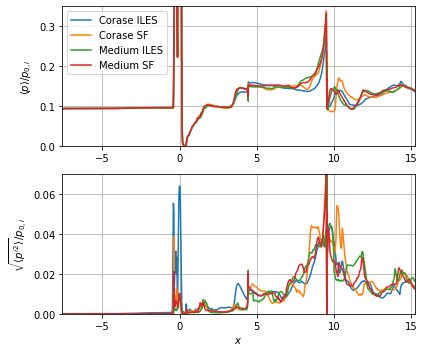

In [126]:
plt.figure(figsize=(6,5))

for i in range(len(all_data)):
  ds = all_data[i]
  T = np.float64(ds.current_time) - t0[i]
  x, p_mean, p_var = getWallPressure(ds, T)

  plt.subplot(2,1,1)
  plt.plot(x, p_mean/p0i, label=all_names[i])

  plt.subplot(2,1,2)
  plt.plot(x, np.sqrt(np.maximum(p_var, 0.0))/p0i)

plt.subplot(2,1,1)  
plt.ylabel(r"$\langle p\rangle / p_{0,i}$")
plt.xlim((x[0], x[-1]))
plt.ylim((0, 0.35))
plt.grid()
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.xlim((x[0], x[-1]))
plt.ylim((0, 0.07))
plt.grid()
plt.ylabel(r"$\sqrt{\langle {p^\prime}^2\rangle} / p_{0,i}$")
plt.xlabel(r"$x$")

plt.tight_layout()

if save_figure:
  plt.savefig("output1.png", facecolor='white')

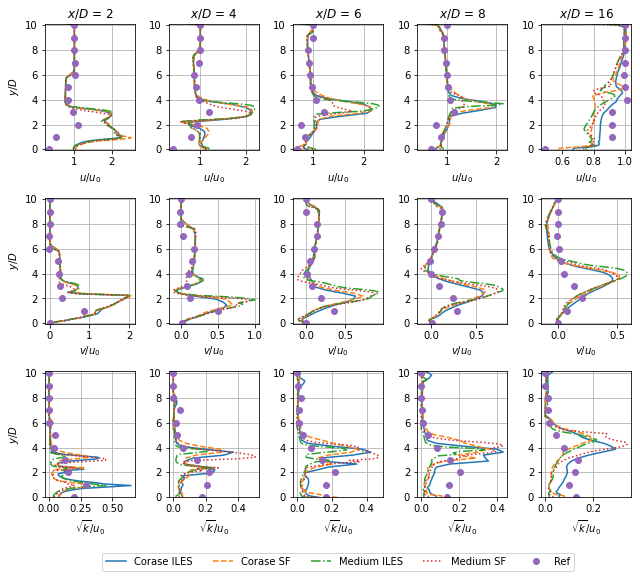

In [127]:
plt.figure(figsize=(9,8))
u0 = 107575
xloc=(2,4,6,8,16) #Rebeiro
# xloc=(2,8,20,29,38)
D = 0.249 # jet diameter

# Plot
for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  y, u_mean, v_mean, tke = getVelocityProfile(ds, T, xloc)
  for i in range(5):
    plt.subplot(3,5,i+1)
    plt.plot(u_mean[i]/u0, y[i], line_styles[j])

    plt.subplot(3,5,i+6)
    plt.plot(v_mean[i]/u0, y[i], line_styles[j])

    plt.subplot(3,5,i+11)
    plt.plot(np.sqrt(np.maximum(tke[i],0.0))/u0, y[i], line_styles[j])

# Plot ref data
ref_data = np.genfromtxt("ref_data.csv", delimiter=',', skip_header=2).T
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.plot(ref_data[i*6], ref_data[-1], 'o')

  plt.subplot(3,5,i+6)
  plt.plot(ref_data[i*6+1], ref_data[-1], 'o')

  plt.subplot(3,5,i+11)
  plt.plot(ref_data[i*6+2], ref_data[-1], 'o')

# Prettify
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$u/u_0$")
  plt.title(r"$x/D$ = "+str(xloc[i]))
  plt.grid()

  plt.subplot(3,5,i+6)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$v/u_0$")
  plt.grid()

  plt.subplot(3,5,i+11)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$\sqrt{k}/u_0$")
  plt.grid()

  if i == 0:
    plt.subplot(3,5,i+1)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+6)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+11)
    plt.ylabel(r"$y/D$")

plt.subplot(3,5,13)
plt.legend([], loc='upper center', bbox_to_anchor=(0.5, -0.4)) # to reserve the space
    
plt.tight_layout()

plt.subplot(3,5,13)
plt.legend(all_names+["Ref"], loc='upper center', bbox_to_anchor=(0.5, -0.4), 
           ncol=len(all_names)+1)

if save_figure:
  plt.savefig("output2.png", facecolor='white')

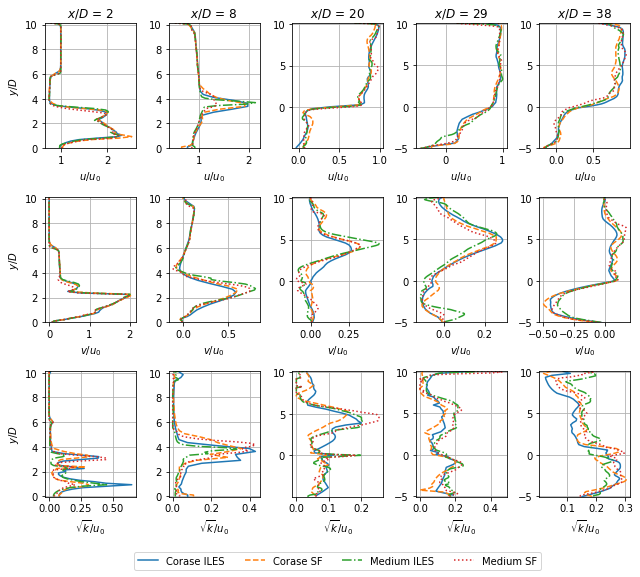

In [128]:
plt.figure(figsize=(9,8))
u0 = 107575
# xloc=(2,4,6,8,16) #Rebeiro
xloc=(2,8,20,29,38)
D = 0.249 # jet diameter

# Plot
for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  y, u_mean, v_mean, tke = getVelocityProfile(ds, T, xloc)
  for i in range(5):
    plt.subplot(3,5,i+1)
    plt.plot(u_mean[i]/u0, y[i], line_styles[j])

    plt.subplot(3,5,i+6)
    plt.plot(v_mean[i]/u0, y[i], line_styles[j])

    plt.subplot(3,5,i+11)
    plt.plot(np.sqrt(np.maximum(tke[i],0.0))/u0, y[i], line_styles[j])

# Prettify
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$u/u_0$")
  plt.title(r"$x/D$ = "+str(xloc[i]))
  plt.grid()

  plt.subplot(3,5,i+6)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$v/u_0$")
  plt.grid()

  plt.subplot(3,5,i+11)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$\sqrt{k}/u_0$")
  plt.grid()

  if i == 0:
    plt.subplot(3,5,i+1)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+6)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+11)
    plt.ylabel(r"$y/D$")

plt.subplot(3,5,13)
plt.legend([], loc='upper center', bbox_to_anchor=(0.5, -0.4)) # to reserve the space
    
plt.tight_layout()

plt.subplot(3,5,13)
plt.legend(all_names, loc='upper center', bbox_to_anchor=(0.5, -0.4), 
           ncol=len(all_names)+1)

if save_figure:
  plt.savefig("output2-2.png", facecolor='white')

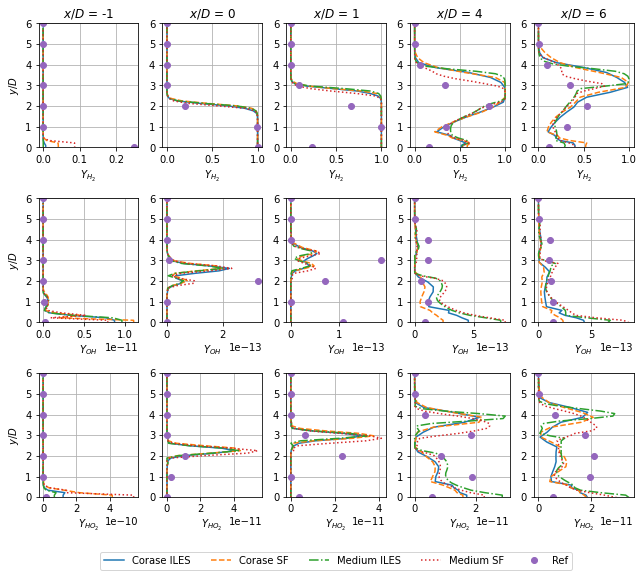

In [129]:
plt.figure(figsize=(9,8))
xloc=(-1,0,1,4,6) #Rebeiro
# xloc=(2,8,20,29,38)

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  y, H2_mean, OH_mean, HO2_mean = getSpeciesProfile(ds, T, xloc)

  for i in range(5):
    plt.subplot(3,5,i+1)
    plt.plot(H2_mean[i][y[i]<6], y[i][y[i]<6], line_styles[j])

    plt.subplot(3,5,i+6)
    plt.plot(OH_mean[i][y[i]<6], y[i][y[i]<6], line_styles[j])

    plt.subplot(3,5,i+11)
    plt.plot(HO2_mean[i][y[i]<6], y[i][y[i]<6], line_styles[j])

ref_data = np.genfromtxt("ref_data.csv", delimiter=',', skip_header=2).T
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.plot(ref_data[i*6+3], ref_data[-1], 'o')

  plt.subplot(3,5,i+6)
  plt.plot(ref_data[i*6+4]*3e-10, ref_data[-1], 'o')

  plt.subplot(3,5,i+11)
  plt.plot(ref_data[i*6+5]*1e-7, ref_data[-1], 'o')

for i in range(5):
  plt.subplot(3,5,i+1)
  # plt.ylim((y[i][0], y[i][-1]))
  plt.ylim((0, 6))
  plt.xlabel(r"$Y_{H_2}$")
  plt.title(r"$x/D$ = "+str(xloc[i]))
  plt.grid()

  plt.subplot(3,5,i+6)
  plt.ylim((0, 6))
  plt.xlabel(r"$Y_{OH}$")
  plt.grid()

  plt.subplot(3,5,i+11)
  plt.ylim((0, 6))
  plt.xlabel(r"$Y_{HO_2}$")
  plt.grid()

  if i == 0:
    plt.subplot(3,5,i+1)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+6)
    plt.ylabel(r"$y/D$")
    plt.subplot(3,5,i+11)
    plt.ylabel(r"$y/D$")

plt.subplot(3,5,13)
plt.legend([], loc='upper center', bbox_to_anchor=(0.5, -0.4)) # to reserve the space
    
plt.tight_layout()

plt.subplot(3,5,13)
plt.legend(all_names+["Ref"], loc='upper center', bbox_to_anchor=(0.5, -0.4), 
           ncol=len(all_names)+1)

if save_figure:
  plt.savefig("output3.png", facecolor='white')

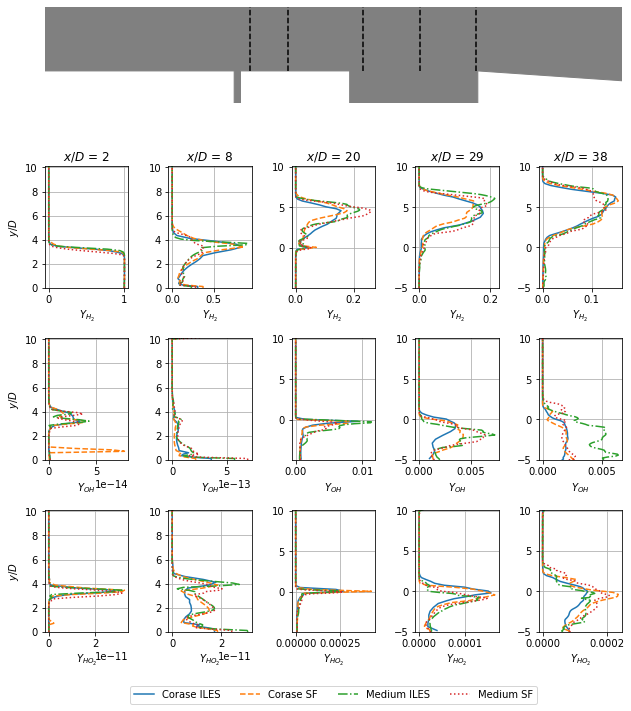

In [130]:
plt.figure(figsize=(9,10))
# xloc=(-1,0,1,4,6) #Rebeiro
xloc=(2,8,20,29,38)

# Draw model
ax = plt.subplot(4,1,1)
polygon1 = Polygon([(-7.62,2.54), (-7.62,0), (-0.1245,0), (-0.1245,-1.27), (0.1245,-1.27), (0.1245,0), 
                    (4.45,0), (4.45,-1.27), (9.525,-1.27), (9.525,0), (15.24,-0.39), (15.24,2.54)], color='grey')
ax.add_patch(polygon1)
for i in range(5):
  ax.plot([xloc[i]*D, xloc[i]*D], [0.0, 2.54], 'k--')
ax.set_xlim(-7.62,15.24)
ax.set_ylim(-1.27,2.54)
ax.set_aspect('equal')
ax.axis('off')

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  y, H2_mean, OH_mean, HO2_mean = getSpeciesProfile(ds, T, xloc)

  for i in range(5):
    plt.subplot(4,5,i+6)
    plt.plot(H2_mean[i], y[i], line_styles[j])

    plt.subplot(4,5,i+11)
    plt.plot(OH_mean[i], y[i], line_styles[j])

    plt.subplot(4,5,i+16)
    plt.plot(HO2_mean[i], y[i], line_styles[j])

for i in range(5):
  plt.subplot(4,5,i+6)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$Y_{H_2}$")
  plt.title(r"$x/D$ = "+str(xloc[i]))
  plt.grid()

  plt.subplot(4,5,i+11)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$Y_{OH}$")
  plt.grid()

  plt.subplot(4,5,i+16)
  plt.ylim((y[i][0], y[i][-1]))
  plt.xlabel(r"$Y_{HO_2}$")
  plt.grid()

  if i == 0:
    plt.subplot(4,5,i+6)
    plt.ylabel(r"$y/D$")
    plt.subplot(4,5,i+11)
    plt.ylabel(r"$y/D$")
    plt.subplot(4,5,i+16)
    plt.ylabel(r"$y/D$")

plt.subplot(4,5,18)
plt.legend([], loc='upper center', bbox_to_anchor=(0.5, -0.4)) # to reserve the space
    
plt.tight_layout()

plt.subplot(4,5,18)
plt.legend(all_names, loc='upper center', bbox_to_anchor=(0.5, -0.4), 
           ncol=len(all_names)+1)

if save_figure:
  plt.savefig("output3-2.png", facecolor='white')

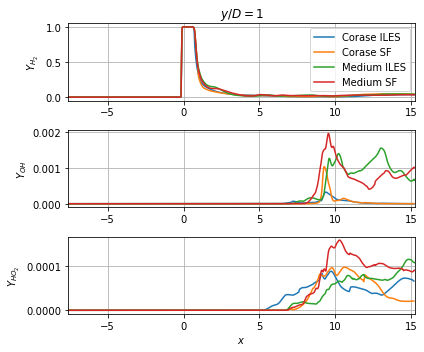

In [131]:
plt.figure(figsize=(6,5))
yloc = 1

D = 0.249

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  x, H2_mean, OH_mean, HO2_mean = getSpeciesLine(ds, T, yloc)

  plt.subplot(3,1,1)
  plt.plot(x*D, H2_mean, label=all_names[j])

  plt.subplot(3,1,2)
  plt.plot(x*D, OH_mean)
  
  plt.subplot(3,1,3)
  plt.plot(x*D, HO2_mean)

plt.subplot(3,1,1)
plt.ylabel(r"$Y_{H_2}$")
plt.xlim((x[0]*D, x[-1]*D))
plt.grid()
plt.title(r"$y/D = $"+str(yloc))
plt.legend()

plt.subplot(3,1,2)
plt.ylabel(r"$Y_{OH}$")
plt.xlim((x[0]*D, x[-1]*D))
plt.grid()

plt.subplot(3,1,3)
plt.ylabel(r"$Y_{HO_2}$")
plt.xlim((x[0]*D, x[-1]*D))
plt.grid()
plt.xlabel(r"$x$")

plt.tight_layout()

if save_figure:
  plt.savefig("output4.png", facecolor='white')

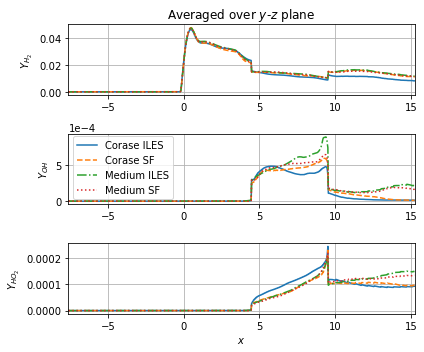

In [133]:
plt.figure(figsize=(6,5))

x = np.linspace(-7.62, 15.24, 768)

# Preparing data for this takes long (>1min), so we load and store them first
H2_mean = []
OH_mean = []
HO2_mean = []
for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  x, A, out2, out3, out4 = getSpeciesLine2(ds, T)
  H2_mean.append(out2)
  OH_mean.append(out3)
  HO2_mean.append(out4)

for j in range(len(all_data)):
  plt.subplot(3,1,1)
  plt.plot(x, H2_mean[j], line_styles[j])

  plt.subplot(3,1,2)
  plt.plot(x, OH_mean[j], line_styles[j], label=all_names[j])
  
  plt.subplot(3,1,3)
  plt.plot(x, HO2_mean[j] * 5, line_styles[j])

plt.subplot(3,1,1)
plt.ylabel(r"$Y_{H_2}$")
plt.xlim((x[0], x[-1]))
plt.grid()
plt.title(r"Averaged over $y$-$z$ plane")

plt.subplot(3,1,2)
plt.ylabel(r"$Y_{OH}$")
plt.xlim((x[0], x[-1]))
plt.grid()
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(3,1,3)
plt.ylabel(r"$Y_{HO_2}$")
plt.xlim((x[0], x[-1]))
plt.grid()
plt.xlabel(r"$x$")

plt.tight_layout()

if save_figure:
  plt.savefig("output5.png", facecolor='white')

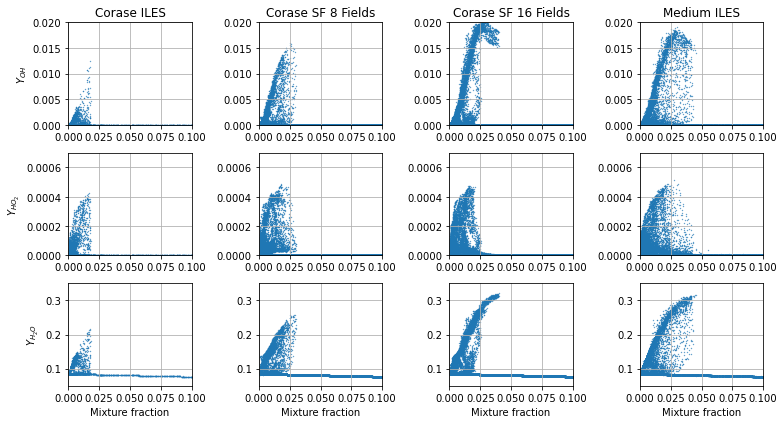

In [14]:
fig = plt.figure(figsize=(11,6))

bx = ((8.0, 8.25), (-1.27, 2.5), (-1.9, 1.9))

for j in range(len(all_data)):
  ds = all_data[j]
  if j == 1:
    Z, OH, HO2, H2O = getScatterData2(ds, 8, bx=bx)

    for n in range(8):
      plt.subplot(3,len(all_data),1+j)
      plt.scatter(Z[n], OH[n], s=0.1, c="C0")

      plt.subplot(3,len(all_data),len(all_data)+1+j)
      plt.scatter(Z[n], HO2[n], s=0.1, c="C0")

      plt.subplot(3,len(all_data),2*len(all_data)+1+j)
      plt.scatter(Z[n], H2O[n], s=0.1, c="C0")

  elif j == 2:
    Z, OH, HO2, H2O = getScatterData2(ds, 16, bx=bx)

    for n in range(16):
      plt.subplot(3,len(all_data),1+j)
      plt.scatter(Z[n], OH[n], s=0.1, c="C0")

      plt.subplot(3,len(all_data),len(all_data)+1+j)
      plt.scatter(Z[n], HO2[n], s=0.1, c="C0")

      plt.subplot(3,len(all_data),2*len(all_data)+1+j)
      plt.scatter(Z[n], H2O[n], s=0.1, c="C0")

  else:
    x, y, z, T, Z, OH, HO2, H2O = getScatterData(ds, bx=bx)
  
    plt.subplot(3,len(all_data),1+j)
    plt.scatter(Z, OH, s=0.1)

    plt.subplot(3,len(all_data),len(all_data)+1+j)
    plt.scatter(Z, HO2, s=0.1)

    plt.subplot(3,len(all_data),2*len(all_data)+1+j)
    plt.scatter(Z, H2O, s=0.1)

for j in range(len(all_data)):
  plt.subplot(3,len(all_data),1+j)
  plt.grid()
  plt.xlim((0, 0.1))
  plt.ylim((0, 0.02))
  plt.title(all_names[j])

  plt.subplot(3,len(all_data),len(all_data)+1+j)
  plt.grid()
  plt.xlim((0, 0.1))
  plt.ylim((0, 7e-4))

  plt.subplot(3,len(all_data),2*len(all_data)+1+j)
  plt.grid()
  plt.xlim((0, 0.1))
  plt.ylim((0.05, 0.35))
  plt.xlabel("Mixture fraction")

plt.subplot(3,len(all_data),1)
plt.ylabel(r"$Y_{OH}$")
plt.subplot(3,len(all_data),len(all_data)+1)
plt.ylabel(r"$Y_{HO_2}$")
plt.subplot(3,len(all_data),2*len(all_data)+1)
plt.ylabel(r"$Y_{H_2O}$")

plt.tight_layout()

# plt.subplot(1,len(all_data),len(all_data))
# plt.colorbar(label=r"$x$")

if save_figure:
  plt.savefig("output6-2.png", facecolor='white')

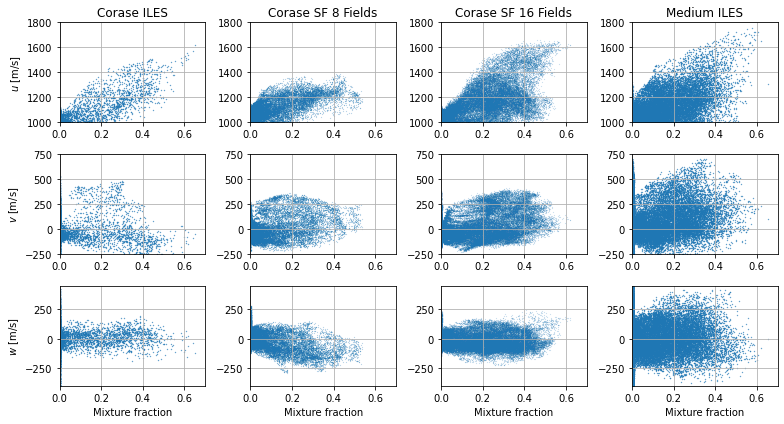

In [45]:
fig = plt.figure(figsize=(11,6))

bx = ((7.0, 7.5), (0.25, 1.5), (-1.9, 1.9))
Nf = [1, 8, 16, 1]

for j in range(len(all_data)):
  ds = all_data[j]
  Z, u, v, w = getScatterData3(ds, Nf[j], bx=bx)

  for n in range(Nf[j]):
    plt.subplot(3, len(all_data), 1+j)
    plt.scatter(Z[n], u[n]/100, s=0.1/Nf[j], c="C0")

    plt.subplot(3,len(all_data),len(all_data)+1+j)
    plt.scatter(Z[n], v[n]/100, s=0.1/Nf[j], c="C0")

    plt.subplot(3,len(all_data),2*len(all_data)+1+j)
    plt.scatter(Z[n], w[n]/100, s=0.1/Nf[j], c="C0")


for j in range(len(all_data)):
  plt.subplot(3,len(all_data),1+j)
  plt.grid()
  plt.xlim((0, 0.7))
  plt.ylim((1000, 1800))
  plt.title(all_names[j])

  plt.subplot(3,len(all_data),len(all_data)+1+j)
  plt.grid()
  plt.xlim((0, 0.7))
  plt.ylim((-250, 750))

  plt.subplot(3,len(all_data),2*len(all_data)+1+j)
  plt.grid()
  plt.xlim((0, 0.7))
  plt.ylim((-400, 450))
  plt.xlabel("Mixture fraction")

plt.subplot(3,len(all_data),1)
plt.ylabel(r"$u$ [m/s]")
plt.subplot(3,len(all_data),len(all_data)+1)
plt.ylabel(r"$v$ [m/s]")
plt.subplot(3,len(all_data),2*len(all_data)+1)
plt.ylabel(r"$w$ [m/s]")

plt.tight_layout()

if save_figure:
  plt.savefig("output6-3.png", facecolor='white')

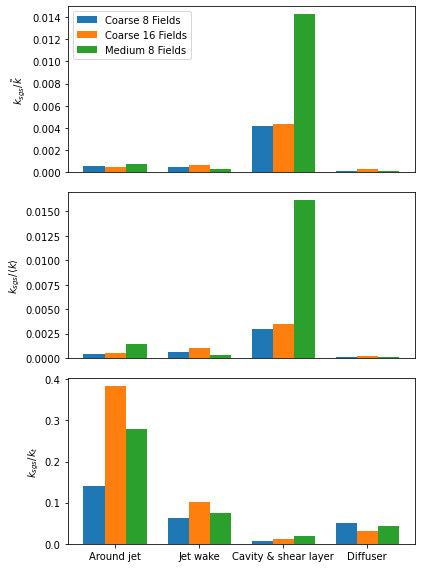

In [137]:
fig = plt.figure(figsize=(6,8))
regions = [((-0.5, 1.0), (0.0, 1.0), (-0.5, 0.5)), # 1: around jet, jet barrel shock
           ((1.0, 4.5), (0.0, 2.5), (-0.75, 0.75)), # 2: jet wake
           ((4.5, 9.5), (-1.27, 0.5), (-0.5, 0.5)), # 3: cavity & shear layer
           ((10.0, 14.0), (0.0, 2.5), (-1.0, 1.0))  # 4: diffuser
          ]
region_names = ["Around jet", "Jet wake", "Cavity & shear layer", "Diffuser"]

bw = 0.75 / len(all_data) # the width of the bars
x = np.arange(len(regions))

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]  
  ratio1 = []
  ratio2 = []
  ratio3 = []
  for i in range(len(regions)):
    k_sgs, k_les, k_rans, tke = getKE(ds, T, bx=(regions[i]))
    ratio1.append(np.mean(k_sgs[k_sgs > 1e5] / k_les[k_sgs > 1e5]))
    ratio2.append(np.mean(k_sgs[k_sgs > 1e5] / k_rans[k_sgs > 1e5]))
    ratio3.append(np.mean(k_sgs[(k_sgs > 1e5) * (tke > 0.1)] / tke[(k_sgs > 1e5) * (tke > 0.1)]))
  
  plt.subplot(3,1,1)
  rect = plt.bar(x + bw*j, ratio1, label=all_names[j], width=bw)
  # plt.bar_label(rect)

  plt.subplot(3,1,2)
  rect = plt.bar(x + bw*j, ratio2, width=bw)
  # plt.bar_label(rect)

  plt.subplot(3,1,3)
  rect = plt.bar(x + bw*j, ratio3, width=bw)
  # plt.bar_label(rect)

plt.subplot(3,1,1)
plt.legend()
plt.xticks([])
plt.ylabel(r"$k_{sgs} / \tilde k$")

plt.subplot(3,1,2)
plt.xticks([])
plt.ylabel(r"$k_{sgs} / \langle k \rangle$")

plt.subplot(3,1,3)
plt.xticks(x + bw*(len(all_data)-1)/2, region_names)
plt.ylabel(r"$k_{sgs} / k_t$")

plt.tight_layout()

if save_figure:
  plt.savefig("output7-1.png", facecolor='white')

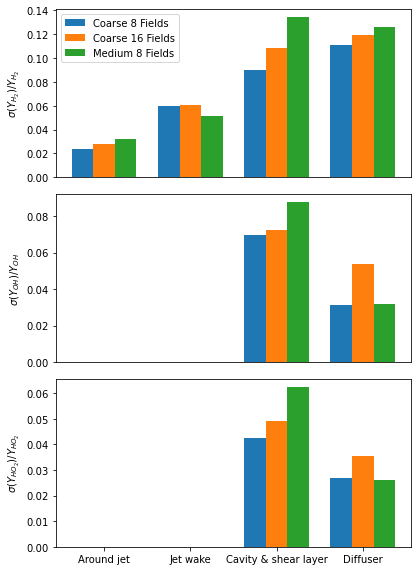

In [138]:
fig = plt.figure(figsize=(6,8))
regions = [((-0.5, 1.0), (0.0, 1.0), (-0.5, 0.5)), # 1: around jet, jet barrel shock
           ((1.0, 4.5), (0.0, 2.5), (-0.75, 0.75)), # 2: jet wake
           ((4.5, 9.5), (-1.27, 0.5), (-0.5, 0.5)), # 3: cavity & shear layer
           ((10.0, 14.0), (0.0, 2.5), (-1.0, 1.0))  # 4: diffuser
          ]
region_names = ["Around jet", "Jet wake", "Cavity & shear layer", "Diffuser"]

bw = 0.75 / len(all_data) # the width of the bars
x = np.arange(len(regions))

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]  
  ratio1 = []
  ratio2 = []
  ratio3 = []
  for i in range(len(regions)):
    H2, OH, HO2 = getVarY(ds, bx=(regions[i]))
    ratio1.append(np.mean(np.sqrt(H2)))
    ratio2.append(np.mean(np.sqrt(OH)))
    ratio3.append(np.mean(np.sqrt(HO2)))
  
  plt.subplot(3,1,1)
  rect = plt.bar(x + bw*j, ratio1, label=all_names[j], width=bw)
  # plt.bar_label(rect)

  plt.subplot(3,1,2)
  rect = plt.bar(x + bw*j, ratio2, width=bw)
  # plt.bar_label(rect)

  plt.subplot(3,1,3)
  rect = plt.bar(x + bw*j, ratio3, width=bw)
  # plt.bar_label(rect)

plt.subplot(3,1,1)
plt.legend()
plt.xticks([])
plt.ylabel(r"$\sigma(Y_{H_2}) / Y_{H_2}$")

plt.subplot(3,1,2)
plt.xticks([])
plt.ylabel(r"$\sigma(Y_{OH}) / Y_{OH}$")

plt.subplot(3,1,3)
plt.xticks(x + bw*(len(all_data)-1)/2, region_names)
plt.ylabel(r"$\sigma(Y_{HO_2}) / Y_{HO_2}$")

plt.tight_layout()

if save_figure:
  plt.savefig("output7-2.png", facecolor='white')

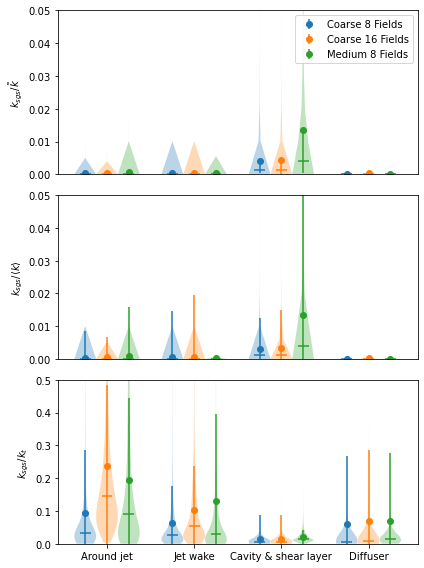

In [143]:
fig = plt.figure(figsize=(6,8))
regions = [((-0.5, 1.0), (0.0, 1.0), (-0.5, 0.5)), # 1: around jet, jet barrel shock
           ((1.0, 4.5), (0.0, 2.5), (-0.75, 0.75)), # 2: jet wake
           ((4.5, 9.5), (-1.27, 0.5), (-0.5, 0.5)), # 3: cavity & shear layer
           ((10.0, 14.0), (0.0, 2.5), (-1.0, 1.0))  # 4: diffuser
          ]
region_names = ["Around jet", "Jet wake", "Cavity & shear layer", "Diffuser"]

bw = 0.75 / len(all_data) # the width of the bars
x = np.arange(len(regions))

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]    
  dat1 = []
  dat2 = []
  dat3 = []
  for i in range(len(regions)):
    k_sgs, k_les, k_rans, tke = getKE(ds, T, bx=(regions[i]))
    dat1.append(np.minimum(k_sgs[k_sgs > 1e5] / k_les[k_sgs > 1e5], 1.0))
    dat2.append(np.minimum(k_sgs[k_sgs > 1e5] / k_rans[k_sgs > 1e5], 1.0))
    dat3.append(np.minimum(k_sgs[(k_sgs > 1e5)] / tke[(k_sgs > 1e5)], 1.0))
  
  plt.subplot(3,1,1)
  plt.violinplot(dat1, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat1], 
               yerr=np.array([(np.mean(dd)-np.percentile(dd,25), np.percentile(dd,75)-np.mean(dd)) for dd in dat1]).T, fmt="o", label=all_names[j], color="C"+str(j))

  plt.subplot(3,1,2)
  plt.violinplot(dat2, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat2], yerr=[np.std(dd) for dd in dat2], fmt="o", label=all_names[j], color="C"+str(j))

  plt.subplot(3,1,3)
  plt.violinplot(dat3, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat3], yerr=[np.std(dd) for dd in dat3], fmt="o", label=all_names[j], color="C"+str(j))

plt.subplot(3,1,1)
plt.legend()
plt.xticks([])
plt.ylim(0.0, 0.05)
plt.ylabel(r"$k_{sgs} / \tilde k$")

plt.subplot(3,1,2)
plt.xticks([])
plt.ylim(0.0, 0.05)
plt.ylabel(r"$k_{sgs} / \langle k \rangle$")

plt.subplot(3,1,3)
plt.xticks(x + bw*(len(all_data)-1)/2, region_names)
plt.ylim(0.0, 0.5)
plt.ylabel(r"$k_{sgs} / k_t$")

plt.tight_layout()

# if save_figure:
#   plt.savefig("output7-1.png", facecolor='white')

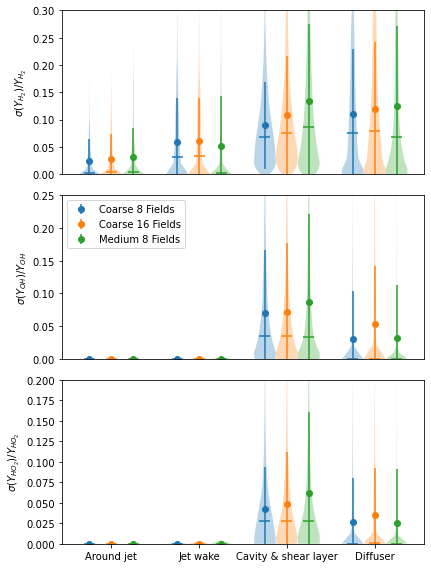

In [144]:
fig = plt.figure(figsize=(6,8))
regions = [((-0.5, 1.0), (0.0, 1.0), (-0.5, 0.5)), # 1: around jet, jet barrel shock
           ((1.0, 4.5), (0.0, 2.5), (-0.75, 0.75)), # 2: jet wake
           ((4.5, 9.5), (-1.27, 0.5), (-0.5, 0.5)), # 3: cavity & shear layer
           ((10.0, 14.0), (0.0, 2.5), (-1.0, 1.0))  # 4: diffuser
          ]
region_names = ["Around jet", "Jet wake", "Cavity & shear layer", "Diffuser"]

bw = 0.75 / len(all_data) # the width of the bars
x = np.arange(len(regions))

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]  
  dat1 = []
  dat2 = []
  dat3 = []
  for i in range(len(regions)):
    H2, OH, HO2 = getVarY(ds, bx=(regions[i]))
    dat1.append(np.sqrt(H2))
    dat2.append(np.sqrt(OH))
    dat3.append(np.sqrt(HO2))
  
  plt.subplot(3,1,1)
  plt.violinplot(dat1, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat1], yerr=[np.std(dd) for dd in dat1], fmt="o", label=all_names[j], color="C"+str(j))

  plt.subplot(3,1,2)
  plt.violinplot(dat2, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat2], yerr=[np.std(dd) for dd in dat2], fmt="o", label=all_names[j], color="C"+str(j))

  plt.subplot(3,1,3)
  plt.violinplot(dat3, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat3], yerr=[np.std(dd) for dd in dat3], fmt="o", label=all_names[j], color="C"+str(j))

plt.subplot(3,1,1)
plt.xticks([])
plt.ylim(0.0, 0.3)
plt.ylabel(r"$\sigma(Y_{H_2}) / Y_{H_2}$")

plt.subplot(3,1,2)
plt.legend(loc='upper left')
plt.xticks([])
plt.ylim(0.0, 0.25)
plt.ylabel(r"$\sigma(Y_{OH}) / Y_{OH}$")

plt.subplot(3,1,3)
plt.xticks(x + bw*(len(all_data)-1)/2, region_names)
plt.ylim(0.0, 0.2)
plt.ylabel(r"$\sigma(Y_{HO_2}) / Y_{HO_2}$")

plt.tight_layout()

# if save_figure:
#   plt.savefig("output7-2.png", facecolor='white')

([<matplotlib.axis.XTick at 0x7fec080c71f0>,
 [Text(0.25, 0, 'Around jet'),
  Text(1.25, 0, 'Jet wake'),
  Text(2.25, 0, 'Cavity & shear layer'),
  Text(3.25, 0, 'Diffuser')])

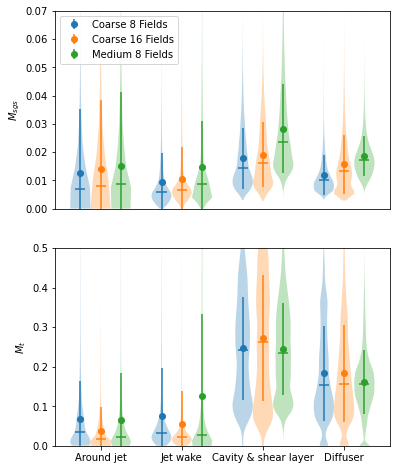

In [145]:
fig = plt.figure(figsize=(6,8))
regions = [((-0.5, 1.0), (0.0, 1.0), (-0.5, 0.5)), # 1: around jet, jet barrel shock
           ((1.0, 4.5), (0.0, 2.5), (-0.75, 0.75)), # 2: jet wake
           ((4.5, 9.5), (-1.27, 0.5), (-0.5, 0.5)), # 3: cavity & shear layer
           ((10.0, 14.0), (0.0, 2.5), (-1.0, 1.0))  # 4: diffuser
          ]
region_names = ["Around jet", "Jet wake", "Cavity & shear layer", "Diffuser"]

bw = 0.75 / len(all_data) # the width of the bars
x = np.arange(len(regions))

for j in range(len(all_data)):
  ds = all_data[j]
  T = np.float64(ds.current_time) - t0[j]
  dat1 = []
  dat2 = []
  for i in range(len(regions)):
    Mt_sgs, Mt = getMt(ds, T, bx=(regions[i]))
    dat1.append(Mt_sgs)
    dat2.append(Mt)
  
  plt.subplot(2,1,1)
  plt.violinplot(dat1, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat1], yerr=[np.std(dd) for dd in dat1], fmt="o", label=all_names[j], color="C"+str(j))

  plt.subplot(2,1,2)
  plt.violinplot(dat2, positions=x + bw*j, showmeans=False, showmedians=True, showextrema=False, widths=bw)
  plt.errorbar(x + bw*j, [np.mean(dd) for dd in dat2], yerr=[np.std(dd) for dd in dat2], fmt="o", label=all_names[j], color="C"+str(j))

plt.subplot(2,1,1)
plt.ylim(0.0, 0.07)
plt.ylabel(r"$M_{sgs}$")
plt.legend(loc='upper left')
plt.xticks([])

plt.subplot(2,1,2)
plt.ylim(0.0, 0.5)
plt.ylabel(r"$M_t$")
plt.xticks(x + bw*(len(all_data)-1)/2, region_names)

# plt.tight_layout()

# if save_figure:
#   plt.savefig("output7-3.png", facecolor='white')